# Adversarial Validationによる特徴量選択

- Train, Testのフラグを付与し、２値分類の学習を行う。
- このときのAUCが低ければ、Train, Test間の分布に差が少なくなっているといえる。
- 特徴量重要度を用いるなどして、AUCを低くしていくことで特徴量選択を行う。
    
 
## 結果


In [132]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('bmh')
%matplotlib inline

from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score

## データ準備

In [133]:
cancer = datasets.load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 全データを使った場合の予測精度
- 3-fold CV
- Random Forest

In [134]:
cv = StratifiedKFold(n_splits=3, shuffle=True)
model = RandomForestClassifier()
cv_result = cross_validate(model, X_train, y_train, cv=cv,  scoring=('accuracy', 'roc_auc'),  
                        return_train_score=True, return_estimator=True, verbose=0)

test_scores = [roc_auc_score(y_test.values, est.predict_proba(X_test)[:, 1]) for est in cv_result['estimator']]

print(f'Cross-validation scores: ')
print('\tTrain:')
print(f"\t  mean: {np.mean(cv_result['test_roc_auc'])}")
print(f"\t  std: {np.std(cv_result['test_roc_auc'])}")
print('\tTest:')
print(f"\t  mean: {np.mean(test_scores)}")
print(f"\t  std: {np.std(test_scores)}")

Cross-validation scores: 
	Train:
	  mean: 0.9856893982489118
	  std: 0.006649780167916818
	Test:
	  mean: 0.9963423954580195
	  std: 0.001957683270776399


## Adversarial Validationを用いた特徴量選択

- Train, Test, Featuerあたりが必要
    - Train Testにフラグ付与
    - データをスタック
        - Featuerでデータを絞る
    - データをセット
    - ここらはinitでやってもいいかもしれない
- Cross Validationで学習
    - cvで学習
- 予測精度、特徴量重要

In [168]:
cancer = datasets.load_breast_cancer()

df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

train, test = train_test_split(df, test_size=0.2, random_state=42)

train.loc[:, 'is_test'] = 0
test.loc[:, 'is_test'] = 1

all_data = pd.concat([train, test], axis=0)
all_data.head()

/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,is_test
68,9.029,17.33,58.79,250.5,0.10660,0.14130,0.31300,0.04375,0.2111,0.08046,...,65.50,324.7,0.14820,0.43650,1.25200,0.17500,0.4228,0.11750,1,0
181,21.090,26.57,142.70,1311.0,0.11410,0.28320,0.24870,0.14960,0.2395,0.07398,...,176.50,2089.0,0.14910,0.75840,0.67800,0.29030,0.4098,0.12840,0,0
63,9.173,13.86,59.20,260.9,0.07721,0.08751,0.05988,0.02180,0.2341,0.06963,...,65.59,310.1,0.09836,0.16780,0.13970,0.05087,0.3282,0.08490,1,0
248,10.650,25.22,68.01,347.0,0.09657,0.07234,0.02379,0.01615,0.1897,0.06329,...,77.98,455.7,0.14990,0.13980,0.11250,0.06136,0.3409,0.08147,1,0
60,10.170,14.88,64.55,311.9,0.11340,0.08061,0.01084,0.01290,0.2743,0.06960,...,69.86,368.6,0.12750,0.09866,0.02168,0.02579,0.3557,0.08020,1,0


In [169]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

class AdValModel():
    
    def __init__(self, train, test, feature, target, seed=42):
        all_data = self.set_all_data(train, test)
        self.feature = feature
        self.seed = seed
        self.imp_df = None
        self.fit(all_data, feature, target)
        pass
    
    
    def set_all_data(self, train, test):
        train['is_test'] = 0
        test['is_test'] = 1
        return pd.concat([train, test], axis=0)
    
    
    def fit(self, all_data, feature, target):
        X = all_data[feature]
        y = all_data[target]
        
        # TODO: ここでtrain_test_splitをしてもいいかもしれない。
        X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        params = {
            'objective': 'binary',
            'metric': 'auc',
            'boosting': 'gbdt',
            'num_iterations': 100,
            'learning_rate': 0.3,
            'num_leaves': 32,
            'max_depth': 5,
            'min_data_in_leaf': 20,
            'bagging_fraction': 1.0,
            'seed': self.seed
        }

        cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
        
        models = []
        auc_scores = []
        for train_index, valid_index in cv.split(X, y):
            X_train, y_train = X.iloc[train_index], y.iloc[train_index]
            X_valid, y_valid = X.iloc[valid_index], y.iloc[valid_index]

            train_data = lgb.Dataset(X_train, y_train)
            valid_data = lgb.Dataset(X_valid, y_valid)

            model = lgb.train(params, train_data, valid_sets=[train_data, valid_data], verbose_eval=0, early_stopping_rounds=10)
            models.append(model)
            
        importances = [models[i].feature_importance() for i in range(len(models))]
        imp_df = pd.DataFrame(importances, columns=feature, index=[f'model_{i}' for i in range(len(models))]).T
        imp_df['AVG_importance'] = imp_df.mean(axis=1)
        
        self.imp_df = imp_df.sort_values(by='AVG_importance')
        self.scores = [roc_auc_score(y_test, m.predict(X_test)) for m in models]
        
        
        
    def plot_importance(self, figsize=(7, 10)):
        self.imp_df['AVG_importance'].plot.barh(figsize=figsize)
        plt.xlabel("Feature Importance")
        plt.show()
        
    
    def get_importance_feature(self, max_num=5):
        if max_num is None:
            max_num = len(self.feature)
        return imp_df.index[-max_num:].tolist()
            
        
    
feature = train.columns.tolist()
cols_to_drop = ['target', 'is_test']
feature = [f for f in feature if f not in cols_to_drop]
target = 'is_test'

adval_model = AdValModel(train, test, feature, target)

<ipython-input-169-a241fba72ce7>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['is_test'] = 0
<ipython-input-169-a241fba72ce7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['is_test'] = 1
/Users/rui/.local/share/virtualenvs/data_science_bowl-_c7OiX6v/lib/python3.8/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


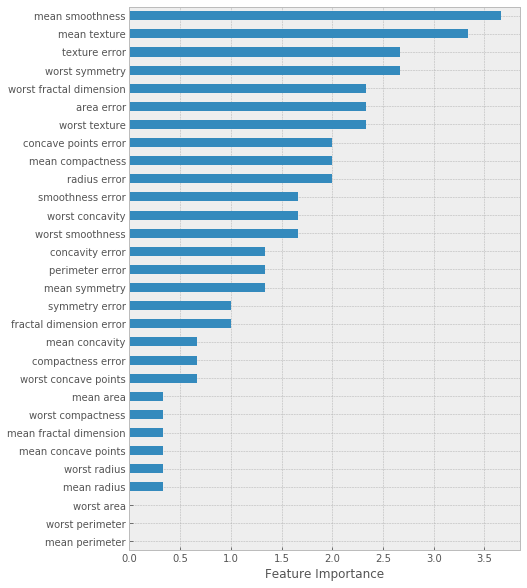

In [170]:
adval_model.plot_importance()

In [171]:
# AUCの精度を確認 redict
pred = np.mean(adval_model.scores, axis=0)
print(f'Average AUC scores: {pred}')

Average AUC scores: 0.546788370520622


In [172]:
cols_to_drop = adval_model.get_importance_feature(max_num=5)
cols_to_drop

['texture error',
 'worst texture',
 'mean smoothness',
 'smoothness error',
 'worst smoothness']

In [173]:
X = df.drop(['target']+cols_to_drop, axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

cv = StratifiedKFold(n_splits=3, shuffle=True)
model = RandomForestClassifier()
cv_result = cross_validate(model, X_train, y_train, cv=cv,  scoring=('accuracy', 'roc_auc'),  
                        return_train_score=True, return_estimator=True, verbose=0)

test_scores = [roc_auc_score(y_test.values, est.predict_proba(X_test)[:, 1]) for est in cv_result['estimator']]

print(f'Cross-validation scores: ')
print('\tTrain:')
print(f"\t  mean: {np.mean(cv_result['test_roc_auc'])}")
print(f"\t  std: {np.std(cv_result['test_roc_auc'])}")
print('\tTest:')
print(f"\t  mean: {np.mean(test_scores)}")
print(f"\t  std: {np.std(test_scores)}")

Cross-validation scores: 
	Train:
	  mean: 0.9884484030800685
	  std: 0.007505399094862646
	Test:
	  mean: 0.9944862976307457
	  std: 0.0015613439945491132
